## Building neural network models for garnets

This example uses the original data from our recent work.

```Ye, W., Chen, C., Wang, Z., Chu, I. H., & Ong, S. P. (2018). Deep neural networks for accurate predictions of crystal stability. Nature communications, 9(1), 1-6.```


In this example we are going to predict the formation energy of garnet crystals (C<sub>3</sub>A<sub>2</sub>D<sub>3</sub>O<sub>12</sub>).

Where the A site can be 
```
Li+, Dy3+, Y3+, Ho3+, Er3+, Tm3+, Lu3+, Hf4+, Mg2+, Zr4+, Sc3+, Ta5+, Ti4+, Nb5+,
Al3+, Zn2+, Cr3+, In3+, Ga3+, Sn4+, Ge4+, Sb5+, Ru4+, Rh3+
```

C site can be
```
Ba2+, Na+, Sr2+, Ca2+, Tb3+, La3+, Pr3+, Nd3+, Sm3+, Gd3+, Eu3+, Dy3+, Y3+, Ho3+,
Er3+, Tm3+, Lu3+, Hf4+, Mg2+, Zr4+, Zn2+, Cd2+, Bi3+
```

D site can be 
```
Li+, Ti4+, Al3+, Ga3+, Si4+, Sn4+, Ge4+, As5+, P5+
```

### Load data

I have processed the data from its formula and saved it in the `garnet.csv` file. We are going to use `pandas` package to work with the data.

In [1]:
import pandas as pd

data = pd.read_csv('./garnet.csv')

data.head()  # examine the first five rows of the data

,c,a,d,C-IonicRadius,C-ElectroNegativity,A-IonicRadius,A-ElectroNegativity,D-IonicRadius,D-ElectroNegativity,FormEnergyPerAtom
0,Gd3+,Sc3+,Al3+,1.075,1.20,0.885,1.36,0.675,1.61,-0.048480
1,Ca2+,Sc3+,Ti4+,1.140,1.00,0.885,1.36,0.745,1.54,-0.140997
2,Cd2+,Cr3+,Ge4+,1.090,1.69,0.755,1.66,0.670,2.01,-0.087724
3,Mg2+,Al3+,Ge4+,0.860,1.31,0.675,1.61,0.670,2.01,-0.037325
4,Cd2+,Tm3+,Ti4+,1.090,1.69,1.020,1.25,0.745,1.54,0.004684


For those who are interested of getting the atom properties. I suggest the use of `pymatgen`. For example the following code is used to compute the electronegativity from a specie (element with charge, e.g., Fe3+). 

```python

from pymatgen import Specie

specie = Specie.from_string("Fe3+")
en = specie.X  # electronegativity, noted as X
ionic_radius = specie.ionic_radius  # ionic radius

```

### Exploratory data analysis

In [2]:
%matplotlib inline  
# this will make sure the plots are shown in the notebook

import matplotlib.pyplot as plt

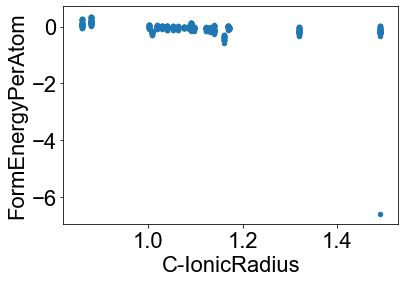

In [3]:

plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'


data.plot(x='C-IonicRadius', y='FormEnergyPerAtom', kind='scatter')

There is one point at with extremely low formation energy per atom. 

In [4]:
data[data['FormEnergyPerAtom']<-5]

,c,a,d,C-IonicRadius,C-ElectroNegativity,A-IonicRadius,A-ElectroNegativity,D-IonicRadius,D-ElectroNegativity,FormEnergyPerAtom
650,Ba2+,Yb3+,Ti4+,1.49,0.89,1.008,1.1,0.745,1.54,-6.568144


We did some check and found that there are some problems with the calculations of Yb-containing compounds.

In [5]:
data = data[data['FormEnergyPerAtom']>=-5]  # discard that data point

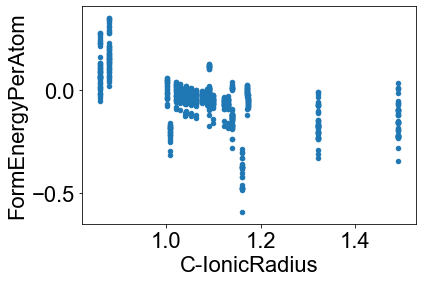

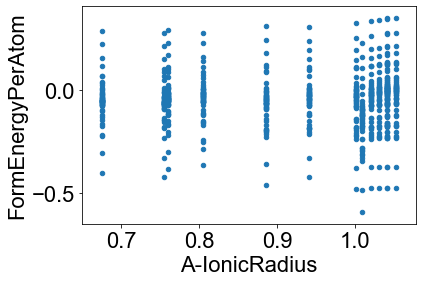

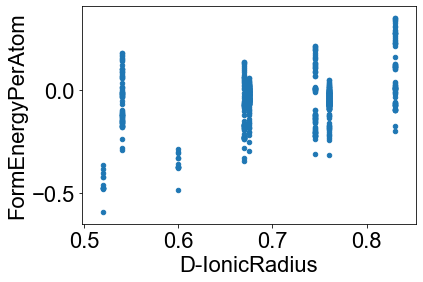

In [6]:
[data.plot(x='%s-IonicRadius' % i, y='FormEnergyPerAtom', kind='scatter') for i in ['C', 'A', 'D']]

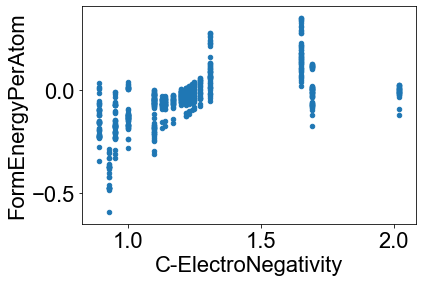

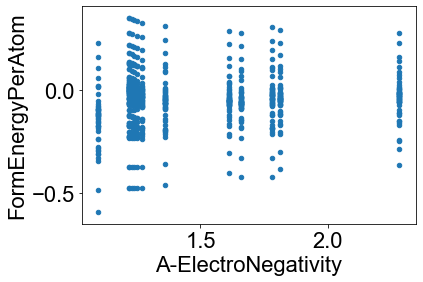

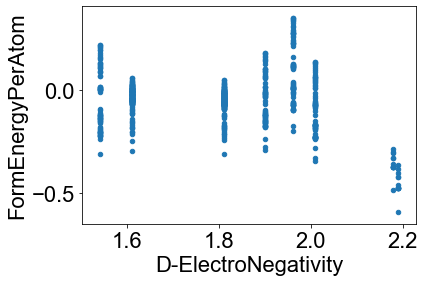

In [7]:
[data.plot(x='%s-ElectroNegativity' % i, y='FormEnergyPerAtom', kind='scatter') for i in ['C', 'A', 'D']]

So far so good. But we also notice that the input spaces are discrete, hence we do not expect to have continuous input supports.

### Modeling

First let's split the data into train and test.

In [8]:
feature_labels = ['%s-IonicRadius' % i for i in ['C', 'A', 'D']] +\
    ['%s-ElectroNegativity' % i for i in ['C', 'A', 'D']]

X = data[feature_labels]
y = data['FormEnergyPerAtom']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)  # 10% as test

### Linear model

It does not hurt to start from a linear model and see what the linear model performs before moving to more complex models.

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's evaluate the model on the test data

In [10]:
from sklearn.metrics import mean_absolute_error


r2_test = lr.score(X_test, y_test) # by default the score func calculates R2 for regression tasks
y_test_pred = lr.predict(X_test)  # model predicted test data 
mae_test = mean_absolute_error(y_test, y_test_pred)  # calculates


print(f"Linear regression gives R^2 score of {r2_test:.3f} and MAE of {mae_test:.3f} eV/atom")

Linear regression gives R^2 score of 0.578 and MAE of 0.055 eV/atom


Note that this is just one random split, and the results varies everytime you run the code. To make more fair judgement, we can do a cross-validation.

In [11]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score


cv_y_lr = cross_val_predict(LinearRegression(), X, y, cv=10)

cv_r2_scores = r2_score(y, cv_y_lr)
cv_mae_scores = mean_absolute_error(y, cv_y_lr)


print(f"Linear regression CV R^2 score is {cv_r2_scores.mean(): .3f}," 
      f"and MAE is {cv_mae_scores.mean(): .3f} eV/atom")

Linear regression CV R^2 score is  0.547,and MAE is  0.064 eV/atom


The results do not look very good. We can show them visually.

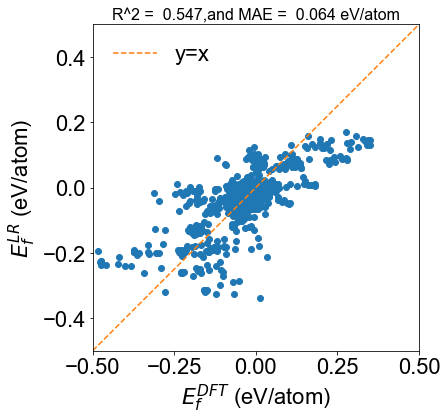

In [12]:
plt.figure(figsize=(6, 6))

plt.plot(y, cv_y_lr, 'o')
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.plot([-0.5, 0.5], [-0.5, 0.5], '--', label='y=x')
plt.legend(frameon=False)
plt.title(f"R^2 = {cv_r2_scores.mean(): .3f}," 
          f"and MAE = {cv_mae_scores.mean(): .3f} eV/atom", fontdict={'fontsize': 16})
plt.xlabel("$E_f^{DFT}$ (eV/atom)")
plt.ylabel("$E_f^{LR}$ (eV/atom)")
plt.gca().set_aspect('equal', 'box')

## Artificial neural networks

In [18]:
from keras.models import Sequential
from keras.layers import Dense

## Construct a simple multi-layer perceptron model 
model = Sequential()
model.add(Dense(128, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile("adam", "mae")

Neural network is sensitive to feature absolute values. Therefore, we need to first scale the features

In [19]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)

X_train_scale = ss.transform(X_train)
X_test_scale = ss.transform(X_test)

Fit the model

In [20]:
model.fit(X_train_scale, y_train, epochs=100)

Epoch 1/100
633/633 [==============================] - 0s 415us/step - loss: 0.0679
Epoch 2/100
633/633 [==============================] - 0s 86us/step - loss: 0.0386
Epoch 3/100
633/633 [==============================] - 0s 96us/step - loss: 0.0310
Epoch 4/100
633/633 [==============================] - 0s 88us/step - loss: 0.0291
Epoch 5/100
633/633 [==============================] - 0s 78us/step - loss: 0.0256
Epoch 6/100
633/633 [==============================] - 0s 75us/step - loss: 0.0225
Epoch 7/100
633/633 [==============================] - 0s 65us/step - loss: 0.0240
Epoch 8/100
633/633 [==============================] - 0s 65us/step - loss: 0.0219
Epoch 9/100
633/633 [==============================] - 0s 64us/step - loss: 0.0205
Epoch 10/100
633/633 [==============================] - 0s 68us/step - loss: 0.0229
Epoch 11/100
633/633 [==============================] - 0s 63us/step - loss: 0.0208
Epoch 12/100
633/633 [==============================] - 0s 63us/step - loss: 0.0187


633/633 [==============================] - 0s 115us/step - loss: 0.0094
Epoch 99/100
633/633 [==============================] - 0s 137us/step - loss: 0.0088
Epoch 100/100
633/633 [==============================] - 0s 145us/step - loss: 0.0084


In [21]:
y_test_pred = model.predict(X_test_scale)

mae_test_ann = mean_absolute_error(y_test_pred, y_test)
mae_test_ann

0.017528561878890247

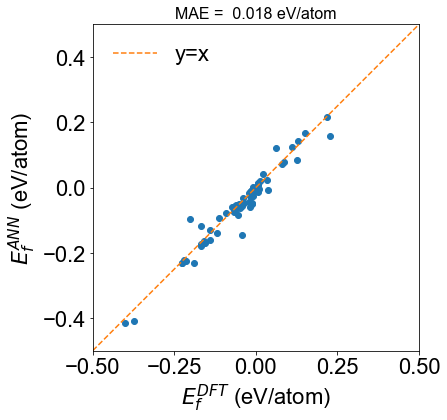

In [22]:
plt.figure(figsize=(6, 6))

plt.plot(y_test, y_test_pred, 'o')
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.plot([-0.5, 0.5], [-0.5, 0.5], '--', label='y=x')
plt.legend(frameon=False)
plt.title(f"MAE = {mae_test_ann: .3f} eV/atom", fontdict={'fontsize': 16})
plt.xlabel("$E_f^{DFT}$ (eV/atom)")
plt.ylabel("$E_f^{ANN}$ (eV/atom)")
plt.gca().set_aspect('equal', 'box')

As you can see, the model erros have reduced substantially compared to the linear model. 

We can further do a cross-validation on using the new model to get a more reliable result.